## Load data

In [318]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
random_state = 12041500

In [346]:
df_train = pd.read_csv("./data2/synthetic_data_DataSynthesizer_correlated_attribute_mode.csv")
df_test = pd.read_json("./data2/testset.json")

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = ["education-num"]
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
target = 'income'

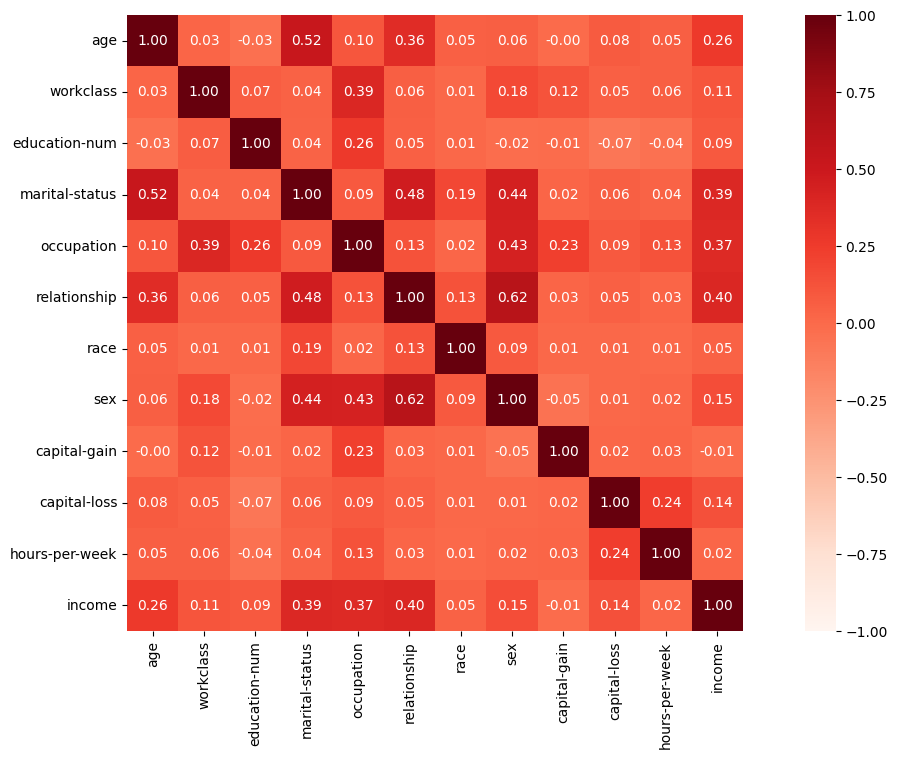

In [347]:
from dython.nominal import associations
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
r = associations(df_train, ax = ax, cmap = "Reds")

### Introduce (additional) sampling bias

In [399]:
from sklearn.utils import resample

data_less_equal_50k_Husband = df_train[df_train['income'] == 0 & (df_train['relationship'] == 'Husband')]
data_greater_50k_Husband = df_train[df_train['income'] == 1 & (df_train['relationship'] == 'Husband')]
data_unequal_Husbad = df_train[(df_train['relationship'] != 'Husband')]

data_less_equal_50k_Husband_undersampled = resample(data_less_equal_50k_Husband, replace=False, n_samples=int(len(data_less_equal_50k)*0.25), random_state=random_state)

biased_data = pd.concat([data_unequal_Husbad, data_greater_50k_Husband, data_less_equal_50k_Husband_undersampled])

df_train = biased_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
df_train.drop_duplicates(inplace=True)

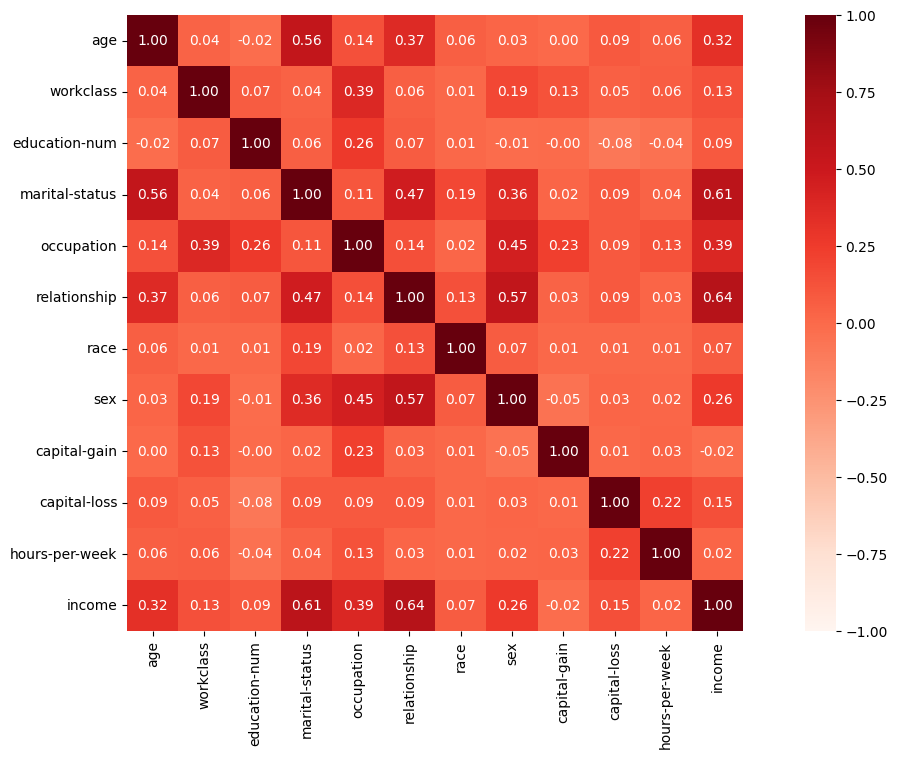

In [402]:
fig, ax = plt.subplots(figsize=(16, 8))
r = associations(df_train, ax = ax, cmap = "Reds")

## Train baseline

In [360]:
from sklearn.linear_model import LogisticRegression
from utils import create_model, train_and_evaluate, describe_model

In [361]:
clf = LogisticRegression(max_iter=1000, random_state=random_state)

In [362]:
## Train baseline
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.7591721542803387
Precision      0.706677900080498
Recall         0.7646875429524592
F1             0.7169499876108296


## Fairness Evaluation

In [364]:
from utils import split_data
from utils_fairness import search_bias, calc_fairness_score, explain_detected_bias

In [366]:
X_train, y_train = split_data(df_train, target, drop_na=True)

In [367]:
model = create_model(clf, nominal_features)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1]) # we select for target label

In [368]:
privileged_subset, _ = search_bias(X_train, y_train, probs, 1, penalty=25)

In [369]:
print(privileged_subset)

({'age': [20.0, 23.0, 24.0]}, 3.0492)


In [370]:
calc_fairness_score(df_train, privileged_subset[0].keys(), target, verbose=True)

Sensitive Attributes: ['age']

             Group Distance  Proportion  Counts   P-Value
age [17.00, 22.00]   -0.248    0.120628    4590 4.94e-324
age [22.00, 26.00]   -0.204    0.089091    3390 1.57e-207
age [46.00, 53.00]    0.158    0.116659    4439 3.70e-114
age [42.00, 46.00]    0.121    0.091956    3499  7.77e-55
age [38.00, 42.00]    0.113    0.098972    3766  5.77e-52
age [26.00, 30.00]   -0.101    0.096371    3667  2.66e-47
age [61.00, 90.00]    0.105    0.097448    3708  4.18e-44
age [53.00, 61.00]    0.089    0.085044    3236  6.69e-29
age [30.00, 34.00]   -0.034    0.115214    4384  1.86e-07
age [34.00, 38.00]    0.036    0.088618    3372  2.40e-06

Weighted Mean Statistical Distance: 0.12361860578392513


In [371]:
explain_detected_bias(df_train, probs, target, privileged_subset[0])

Our detected privileged group has a size of 2782, we observe 0.0183 as the average probability of earning >50k, but our model predicts 0.322


## Fairness Metrics

In [372]:
from utils_fairness import transform_to_bias_dataset, describe_fairness, scan_and_calculate_fairness, plot_fairness_metrics

In [373]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

848 Na rows removed!
202 Na rows removed!


In [374]:
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_train, target, drop_na=True)
metrics = describe_fairness(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   0.3215538402101501
average_odds_difference         0.33668352589831285
equal_opportunity_difference    0.5765316439943688
disparate_impact                19.577042313959126
theil_index                     0.10014557035236983


In [375]:
df_fairness_metrics, priviliged_subsets = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
), {}

for i in [0.001, 0.01, 0.1, 1, 5, 25, 50, 100]:
    metrics, priv = scan_and_calculate_fairness(model, df_train, target, i)    
    df_fairness_metrics.loc[f"penalty_{i}"] = metrics.values()
    priviliged_subsets[f"penalty_{i}"] = priv

In [376]:
df_fairness_metrics

,statistical_parity_difference,average_abs_odds_difference,equal_opportunity_difference,disparate_impact,theil_index
penalty_0.001,0.127370,0.253466,0.504884,2.447705,0.166034
penalty_0.01,0.151786,0.264823,0.504884,3.179710,0.166034
penalty_0.1,0.108631,-0.261179,-0.495214,1.981812,0.166034
penalty_1,0.132048,-0.025097,-0.081797,2.346142,0.166034
penalty_5,0.150249,0.004117,-0.035875,2.786224,0.166034
penalty_25,0.202309,0.168962,0.251901,10.027302,0.166034
penalty_50,0.000000,0.000000,0.000000,1.000000,0.000000
penalty_100,0.000000,0.000000,0.000000,1.000000,0.000000


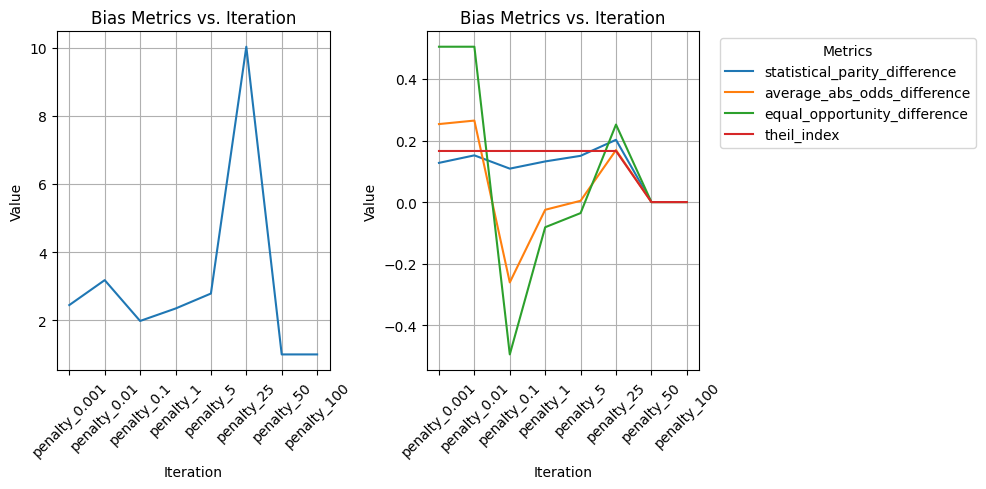

In [377]:
plot_fairness_metrics(df_fairness_metrics)

## Mitigation

In [378]:
from tqdm import tqdm
from sklearn import clone
from aif360.algorithms.preprocessing import Reweighing
from utils_fairness import create_aif360_standardDataset, compute_metrics, reweight_mitigation
from utils import plot_metrics

### Reweighting

In [379]:
# create (un)privileged groups
privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

# convert dataset
train_dataset = create_aif360_standardDataset(df_train, nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))
test_dataset = create_aif360_standardDataset(df_test, nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))

# train model
model = clone(clf)
model.fit(train_dataset.features, train_dataset.labels.ravel())
y_pred = model.predict(train_dataset.features)

# model = create_model(clf, nominal_features)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_train)

# compare results
train_dataset_prediction = train_dataset.copy()
train_dataset_prediction.labels = y_pred.reshape(-1, 1)
train_dataset_prediction.scores = y_pred.reshape(-1, 1)
_ = compute_metrics(train_dataset, train_dataset_prediction, unprivileged_groups, privileged_groups)

Statistical parity difference = 0.3102
Disparate impact = 40.4263
Average odds difference = 0.3458
Equal opportunity difference = 0.5991
Theil index = 0.1105


In [380]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(train_dataset)

train_dataset_reweight = RW.transform(train_dataset)

In [381]:
model = create_model(clf, nominal_features)

# original model
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=None)
_ = describe_model(y_test, y_pred, verbose=True)

# mitigated model
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=train_dataset_reweight.instance_weights)
_ = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.7591721542803387
Precision      0.706677900080498
Recall         0.7646875429524592
F1             0.7169499876108296
Metric         Value               
Accuracy       0.7672206543326017
Precision      0.7106011634778355
Recall         0.7650862494352256
F1             0.7225719620541076


In [382]:
def check_equal_index(standard_dataset, df_compare):
    df1, _ = standard_dataset.convert_to_dataframe()
    return df1.index.equals(df_compare.index)

In [383]:
check_equal_index(train_dataset, df_train.dropna())

False

In [384]:
df_fairness_metrics = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

df_metrics = pd.DataFrame(
    columns=['acc', 'prec', 'rec', 'f1']
)

weights = None

weights_hist = [weights]
max_iter = 10
for i in tqdm(range(max_iter)):
    X_train, y_train = split_data(df_train, target, True)
    X_test, y_test = split_data(df_test, target, True)
    weights, model_metrics, fair_metrics = reweight_mitigation(clf, nominal_features, target, X_train, y_train, X_test, y_test, penalty=25, sample_weights=weights)
    if model_metrics is None and fair_metrics is None and weights is None:
        break

    df_metrics.loc[f"mitigation_{i}"] = model_metrics.values()
    df_fairness_metrics.loc[f"mitigation_{i}"] = fair_metrics.values()
    weights_hist.append(weights)

100%|██████████| 10/10 [07:15<00:00, 43.56s/it]


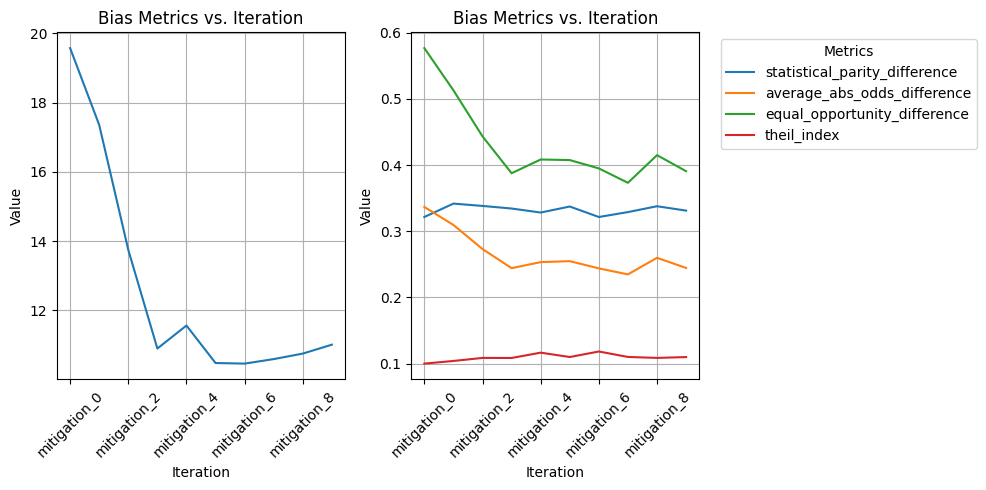

In [385]:
plot_fairness_metrics(df_fairness_metrics)

In [386]:
df_fairness_metrics

,statistical_parity_difference,average_abs_odds_difference,equal_opportunity_difference,disparate_impact,theil_index
mitigation_0,0.321554,0.336684,0.576532,19.577042,0.100146
mitigation_1,0.341751,0.309478,0.512840,17.358934,0.104150
mitigation_2,0.338235,0.273156,0.443266,13.749686,0.108736
mitigation_3,0.334311,0.244255,0.387612,10.901391,0.108645
mitigation_4,0.328236,0.253370,0.408335,11.564791,0.116670
mitigation_5,0.337341,0.254865,0.407466,10.482178,0.110092
mitigation_6,0.321506,0.243931,0.394886,10.465369,0.118416
mitigation_7,0.328943,0.234846,0.373156,10.595535,0.110201
mitigation_8,0.337761,0.259922,0.414902,10.754750,0.108745
mitigation_9,0.331149,0.244551,0.390684,11.012097,0.110024


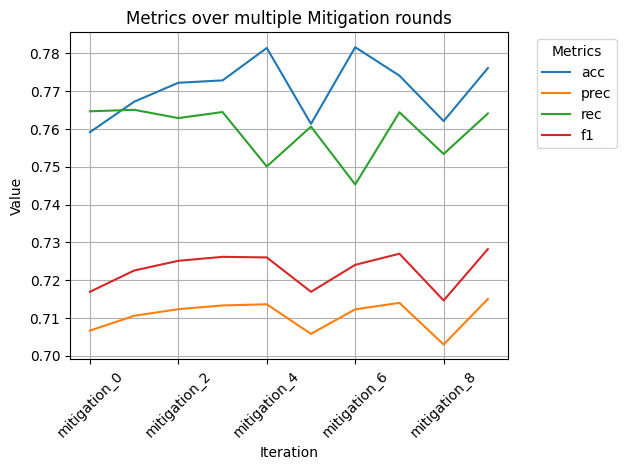

In [387]:
plot_metrics(df_metrics, 'Iteration', 'Value', 'Metrics over multiple Mitigation rounds')

In [388]:
df_metrics

,acc,prec,rec,f1
mitigation_0,0.759172,0.706678,0.764688,0.716950
mitigation_1,0.767221,0.710601,0.765086,0.722572
mitigation_2,0.772238,0.712348,0.762895,0.725147
mitigation_3,0.772865,0.713338,0.764496,0.726189
mitigation_4,0.781436,0.713646,0.750094,0.726041
mitigation_5,0.761367,0.705818,0.760639,0.716945
mitigation_6,0.781645,0.712312,0.745331,0.724074
mitigation_7,0.774119,0.714018,0.764431,0.727017
mitigation_8,0.762099,0.703002,0.753399,0.714656
mitigation_9,0.776105,0.715045,0.764105,0.728242


### Fair Learning

In [389]:
from utils import prepare_data_fair_learning, plot_fairlearning_results
from utils_fairness import get_fair_learning_scoring

In [390]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

X_train, y_train, X_test, y_test = prepare_data_fair_learning(df_train_bias, df_test_bias, nominal_features, target)

848 Na rows removed!
202 Na rows removed!


In [391]:
max_delta = get_fair_learning_scoring(list(privileged_subset[0].keys()))

In [392]:
from sklearn.model_selection import GridSearchCV
from aif360.sklearn.preprocessing import LearnedFairRepresentations

lfr = LearnedFairRepresentations(list(privileged_subset[0].keys()), n_prototypes=25, max_iter=100, random_state=random_state)
params = {
    "reconstruct_weight": [1e-2, 1e-3, 1e-4],
    "target_weight": [100, 1000],
    "fairness_weight": [0, 100, 1000],
}

grid = GridSearchCV(lfr, params, scoring=max_delta, cv=3, n_jobs=-1).fit(X_train, y_train, priv_group=(1,)*len(list(privileged_subset[0].keys())))
res = pd.DataFrame(grid.cv_results_)
display(res)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/m

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fairness_weight,param_reconstruct_weight,param_target_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,19.684514,1.836172,0.175548,0.058153,0,0.0100,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.673438,-0.652630,-0.681080,-0.669049,0.012022,7
1,16.070223,0.835748,0.104108,0.048953,0,0.0100,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.681110,-0.681016,-0.670602,-0.677576,0.004932,11
2,12.862272,7.059117,0.099096,0.083828,0,0.0010,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.681110,-0.681016,-0.681080,-0.681069,0.000039,16
3,16.889240,1.404152,0.101739,0.018669,0,0.0010,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.681110,-0.679374,-0.681080,-0.680521,0.000812,13
4,10.551225,6.490958,0.110305,0.035382,0,0.0001,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.681110,-0.681016,-0.681080,-0.681069,0.000039,16
5,12.877907,0.393331,0.074492,0.013325,0,0.0001,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.661291,-0.651762,-0.669411,-0.660821,0.007213,3
6,17.718144,2.914704,0.087112,0.022445,100,0.0100,100,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.670566,-0.650954,-0.680313,-0.667278,0.012209,4
7,18.464733,2.650917,0.067206,0.021233,100,0.0100,1000,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.649017,-0.474792,-0.679169,-0.600993,0.090082,1
8,19.472622,0.916083,0.051826,0.007072,100,0.0010,100,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.655091,-0.668434,-0.679991,-0.667839,0.010174,5
9,12.937450,1.443473,0.061378,0.013655,100,0.0010,1000,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.665271,-0.681016,-0.681080,-0.675789,0.007437,10


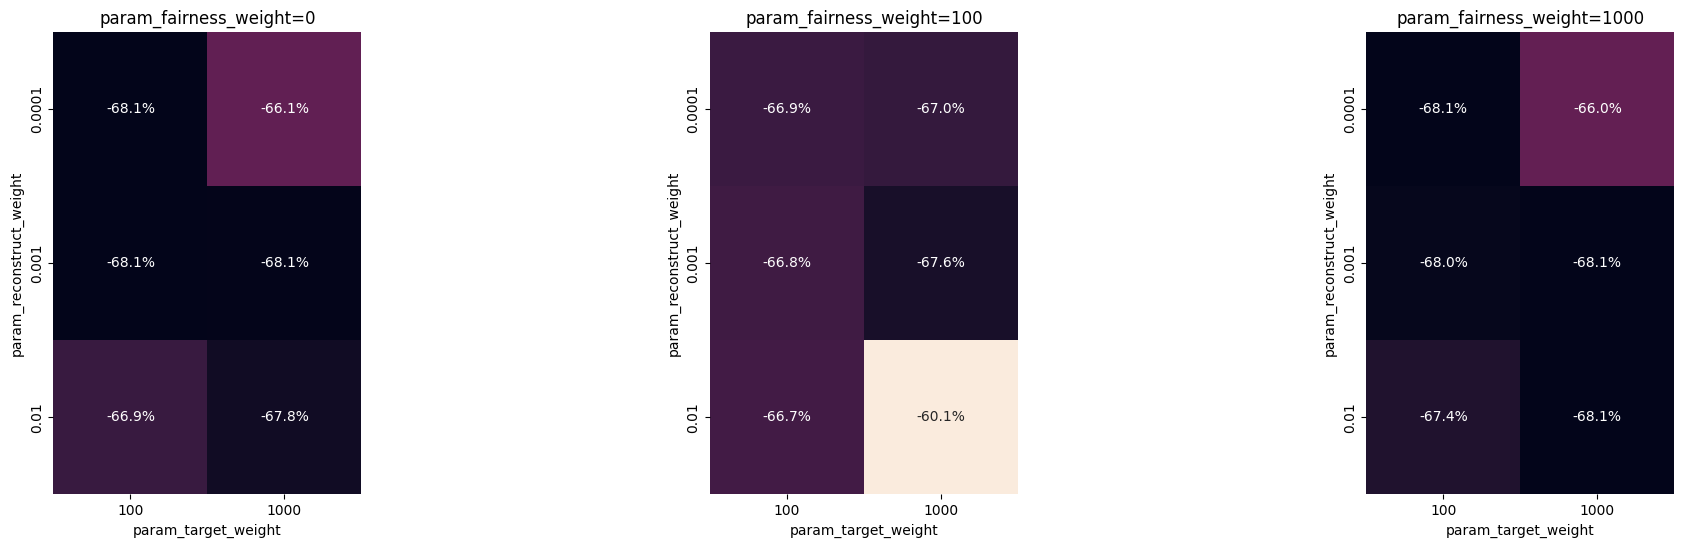

In [394]:
plot_fairlearning_results(res)

In [395]:
model = create_model(clf, [])

In [396]:
model.fit(X_train, y_train)

_ = describe_model(y_test, model.predict(X_test), verbose=True)
_ = describe_fairness(y_train, model.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)

Metric         Value               
Accuracy       0.7678478101808299
Precision      0.7116013134706771
Recall         0.7666869967496988
F1             0.7235953214553105
Metric                          Value               
statistical_parity_difference   0.3189543861243034
average_odds_difference         0.3335143689212577
equal_opportunity_difference    0.5723666301109893
disparate_impact                20.304334512570936
theil_index                     0.10105292174424073


In [397]:
_ = describe_model(y_test, grid.predict(X_test), verbose=True)
_ = describe_fairness(y_train, grid.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)

Metric         Value               
Accuracy       0.7594857322044528
Precision      0.3797428661022264
Recall                     0.5
F1             0.4316521119230084
Metric                          Value               
statistical_parity_difference               0.0
average_odds_difference                     0.0
equal_opportunity_difference                0.0
disparate_impact                            0.0
theil_index                     0.3840921499337831


In [398]:
model.fit(grid.transform(X_train), y_train)

_ = describe_model(y_test, model.predict(X_test), verbose=True)
_ = describe_fairness(y_train, model.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)
_ = describe_fairness(y_train, model.predict(grid.transform(X_train)), list(privileged_subset[0].keys()) ,verbose=True)

Metric         Value               
Accuracy       0.2109334169541131
Precision      0.2813175537299527
Recall         0.37673599709457456
F1             0.19861776114446625
Metric                          Value               
statistical_parity_difference   0.1512777700213106
average_odds_difference         0.18494026959284166
equal_opportunity_difference    0.22781381493493869
disparate_impact                2.866738307738697
theil_index                     0.32184276577814536
Metric                          Value               
statistical_parity_difference   0.0008199369218015711
average_odds_difference         -0.0033721718479503768
equal_opportunity_difference    -0.006021964517659503
disparate_impact                1.0868449856341498
theil_index                     0.3809709950673444


Multiple Runs cannot be done, because of the dataset already needs to be one hot encoded for the mitigation, making the `search_bias` function unnecessary and returning not viable resolutions.

### Fair Adapt